# Get Ouput Per Layer

This notebook gives the model a input and prints the output of each layer.

In [27]:
import torch
from PIL import Image
from torchvision import transforms

from utils.dataloader import VOCDataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((320, 320)),  # Resize to 320x320
    transforms.ToTensor(),         # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Update the dataloader to use the transformations
loader = VOCDataLoader(train=False, batch_size=1)

In [28]:
from tinyyolov2 import TinyYoloV2
from utils.yolo import nms, filter_boxes
from utils.viz import display_result

# make an instance with 20 classes as output
net = TinyYoloV2(num_classes=20)

# load pretrained weights
sd = torch.load("voc_pretrained.pt")
net.load_state_dict(sd)

#put network in evaluation mode
net.eval()

print("Model state dict keys:", net.state_dict().keys())

def hook_fn(module, input, output):
    print(f"Layer: {module}")
    print(f"Output min: {output.min()}, max: {output.max()}\n")
    if torch.isnan(output).any():
        print(f"NaN detected in layer: {module}\n")

for name, module in net.named_modules():
    module.register_forward_hook(hook_fn)


print("------------Checking paramters in checkpoints---------------")
for name, param in net.named_parameters():
    if torch.isnan(param).any():
        print(f"NaN detected in parameter: {name}")
    if torch.isinf(param).any():
        print(f"Inf detected in parameter: {name}")
    print(f"{name}: mean={param.mean().item()}, std={param.std().item()}")


print("-----------Checking if the keys match to the current structure----------------")
net.load_state_dict(torch.load('voc_pretrained.pt'), strict=True)



Model state dict keys: odict_keys(['anchors', 'conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'conv3.weight', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'conv4.weight', 'bn4.weight', 'bn4.bias', 'bn4.running_mean', 'bn4.running_var', 'bn4.num_batches_tracked', 'conv5.weight', 'bn5.weight', 'bn5.bias', 'bn5.running_mean', 'bn5.running_var', 'bn5.num_batches_tracked', 'conv6.weight', 'bn6.weight', 'bn6.bias', 'bn6.running_mean', 'bn6.running_var', 'bn6.num_batches_tracked', 'conv7.weight', 'bn7.weight', 'bn7.bias', 'bn7.running_mean', 'bn7.running_var', 'bn7.num_batches_tracked', 'conv8.weight', 'bn8.weight', 'bn8.bias', 'bn8.running_mean', 'bn8.running_var', 'bn8.num_batches_tracked', 'conv9.weight', 'conv9.bias'])
------------Checking paramters in checkpoints--------------

/var/folders/3p/yjsjgtxs5w75lv_wclnr3n0c0000gn/T/ipykernel_96299/1442998829.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load("voc_pretrained.pt")
/var/fol

<All keys matched successfully>

  0%|                                                  | 0/5823 [00:00<?, ?it/s]

Input tensor shape: torch.Size([1, 3, 320, 320])
Input tensor min: 0.0, max: 1.0


Layer: Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output min: -5.2425689697265625, max: 5.027318477630615

Layer: BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output min: -67.48834991455078, max: 65.77369689941406

Layer: Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output min: -102.1931381225586, max: 47.87655258178711

Layer: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output min: -80.9782943725586, max: 23.749187469482422

Layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output min: -22.41474723815918, max: 20.524412155151367

Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output min: -36.71601867675781, max: 22.97968864440918

Layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddin

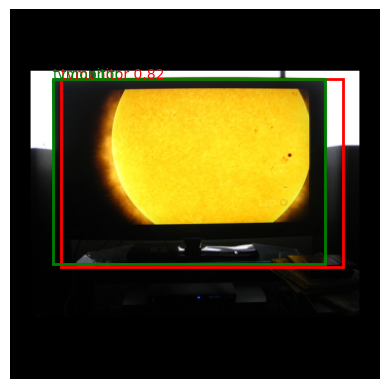

  0%|                                                  | 0/5823 [00:00<?, ?it/s]


In [29]:
import tqdm

its = 1

for idx, (input, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):

    print(f"Input tensor shape: {input.shape}")
    print(f"Input tensor min: {input.min()}, max: {input.max()}")
    print("\n")

    
    #input is a 1 x 3 x 320 x 320 image
    output = net(input)
    "output is of a tensor of size 32 x 125 x 10 x 10"
    #output is a 32 x 125 x 10 x 10 tensor

    #print(output[0].data)
    
    #filter boxes based on confidence score (class_score*confidence)
    output = filter_boxes(output, 0)

    #print(output[0].data)
    
    #filter boxes based on overlap
    output = nms(output, 0)

    #print(output[0].data)
    
    display_result(input, output, target, file_path='yolo_prediction.png')

    its = its - 1

    if its <= 0:
        break